In [ ]:
import numpy as np
import pandas as pd 
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline      
from sklearn.model_selection import GridSearchCV   
from sklearn.datasets import make_multilabel_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score
import seaborn as sns

In [ ]:
def convert_to_binary(val):
    if val >= 1:
        return 1
    else:
        return 0

In [ ]:
def remove_cols_df(df):
    # Threshold for the percentage
    threshold = 0.99
     # List to hold columns that meet the condition
    columns_to_drop = []

    # Loop through each column
    zero_one_cols_b = df.columns[((df == 0).all()) | ((df == 1).all())]
    columns_to_drop.extend(zero_one_cols_b)
    for column in df.columns:
        # Get the highest count of a single value in this column
        max_count = df[column].value_counts().max()

        # Calculate the percentage of this count relative to the total number of rows
        percent = max_count / len(df)

        # Check if this percentage is greater than or equal to the threshold
        if percent >= threshold:
            # Add the column name to the list
            columns_to_drop.append(column)
    
    df = df.drop(columns_to_drop, axis=1)
    return df 


In [ ]:
def plot_distribution(df):
    num_cols = 5  # Number of columns in each row of subplots
    num_rows = (len(df.columns) - 1) // num_cols + 1  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))
    fig.suptitle('Distribution of Binary Values (0s and 1s)')

    for i, col in enumerate(df.columns):
        ax = axes[i // num_cols, i % num_cols]
        df[col].value_counts().plot(kind='bar', ax=ax, color=['skyblue', 'salmon'])
        ax.set_title(col)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.set_xticklabels(['0', '1'], rotation=0)

    # Hide empty subplots if any
    for i in range(len(df.columns), num_rows * num_cols):
        axes.flatten()[i].axis('off')
    plt.tight_layout()
    plt.show()
    return 

In [ ]:
def plot_ROC(estimators,target_names ):

    num_cols = 3  # Number of columns in each row of subplots
    num_rows = (len(estimators) - 1) // num_cols + 1  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    fig.suptitle('ROC Curve Comparison')

    for i, estimator in enumerate(estimators):
        ax = axes[i // num_cols, i % num_cols]

        # Display ROC curve for each estimator on its own subplot
        RocCurveDisplay.from_estimator(clf_svc.estimators_[estimator], X_test, y_test.values[:, estimator], ax=ax)
        RocCurveDisplay.from_estimator(clf_log.estimators_[estimator], X_test, y_test.values[:, estimator], ax=ax)
        RocCurveDisplay.from_estimator(clf_tree.estimators_[estimator], X_test, y_test.values[:, estimator], ax=ax)
    
        # You might want to set individual titles for each subplot
        ax.set_title(f'Estimator {target_names[i]}')

        ax.legend(fontsize='small', loc='lower right', columnspacing=1, handlelength=2)

    # Hide empty subplots if any
    for i in range(len(estimators), num_rows * num_cols):
        axes.flatten()[i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for the main title
    plt.show()
    return 

In [ ]:
df_demands = pd.read_csv("demand_scenarios.csv")[:] # arbitrary removal 

df_demands_lag = df_demands.shift(-1)
df_demands_fut = df_demands.shift(1)

#Add dataframe together 

df_X = pd.concat([df_demands,df_demands_lag,df_demands_fut],axis = 1 ).fillna(0)

#Y targets 

Opt_b_df = pd.read_csv("Opt_b.csv",)[:] #Binary
Opt_f_df = pd.read_csv("Opt_f.csv")[:]

#Rename columns 

# Create a mapping dictionary for renaming columns
mapping_b = {col: f"b_{col}" for col in Opt_b_df.columns}
mapping_f = {col: f"f_{col}" for col in Opt_f_df.columns}

# Rename the columns using the mapping dictionary
Opt_b_df = Opt_b_df.rename(columns=mapping_b)
Opt_f_df = Opt_f_df.rename(columns=mapping_f)

tolerance = 0.98
for col in Opt_b_df.columns:
    Opt_b_df[col] = np.where(Opt_b_df[col] >= tolerance, 1, 0) # Tolereance being quite lenient to make sure all are within 
for col in Opt_f_df.columns:
    Opt_f_df[col] = np.where(Opt_f_df[col] >= tolerance, 1, 0)


Opt_b_df = remove_cols_df(Opt_b_df)
Opt_f_df = remove_cols_df(Opt_f_df)



# Remove columns with all zeros

targets_combined = pd.concat([Opt_b_df,Opt_f_df],axis = 1)

#Count how many zeros and ones in target 

count_zeros = (targets_combined == 0).sum().sum()
count_ones = (targets_combined == 1).sum().sum()


#pick columns (targets with most 1, and one with almost no ones)

target_names = targets_combined.columns # For output of models 

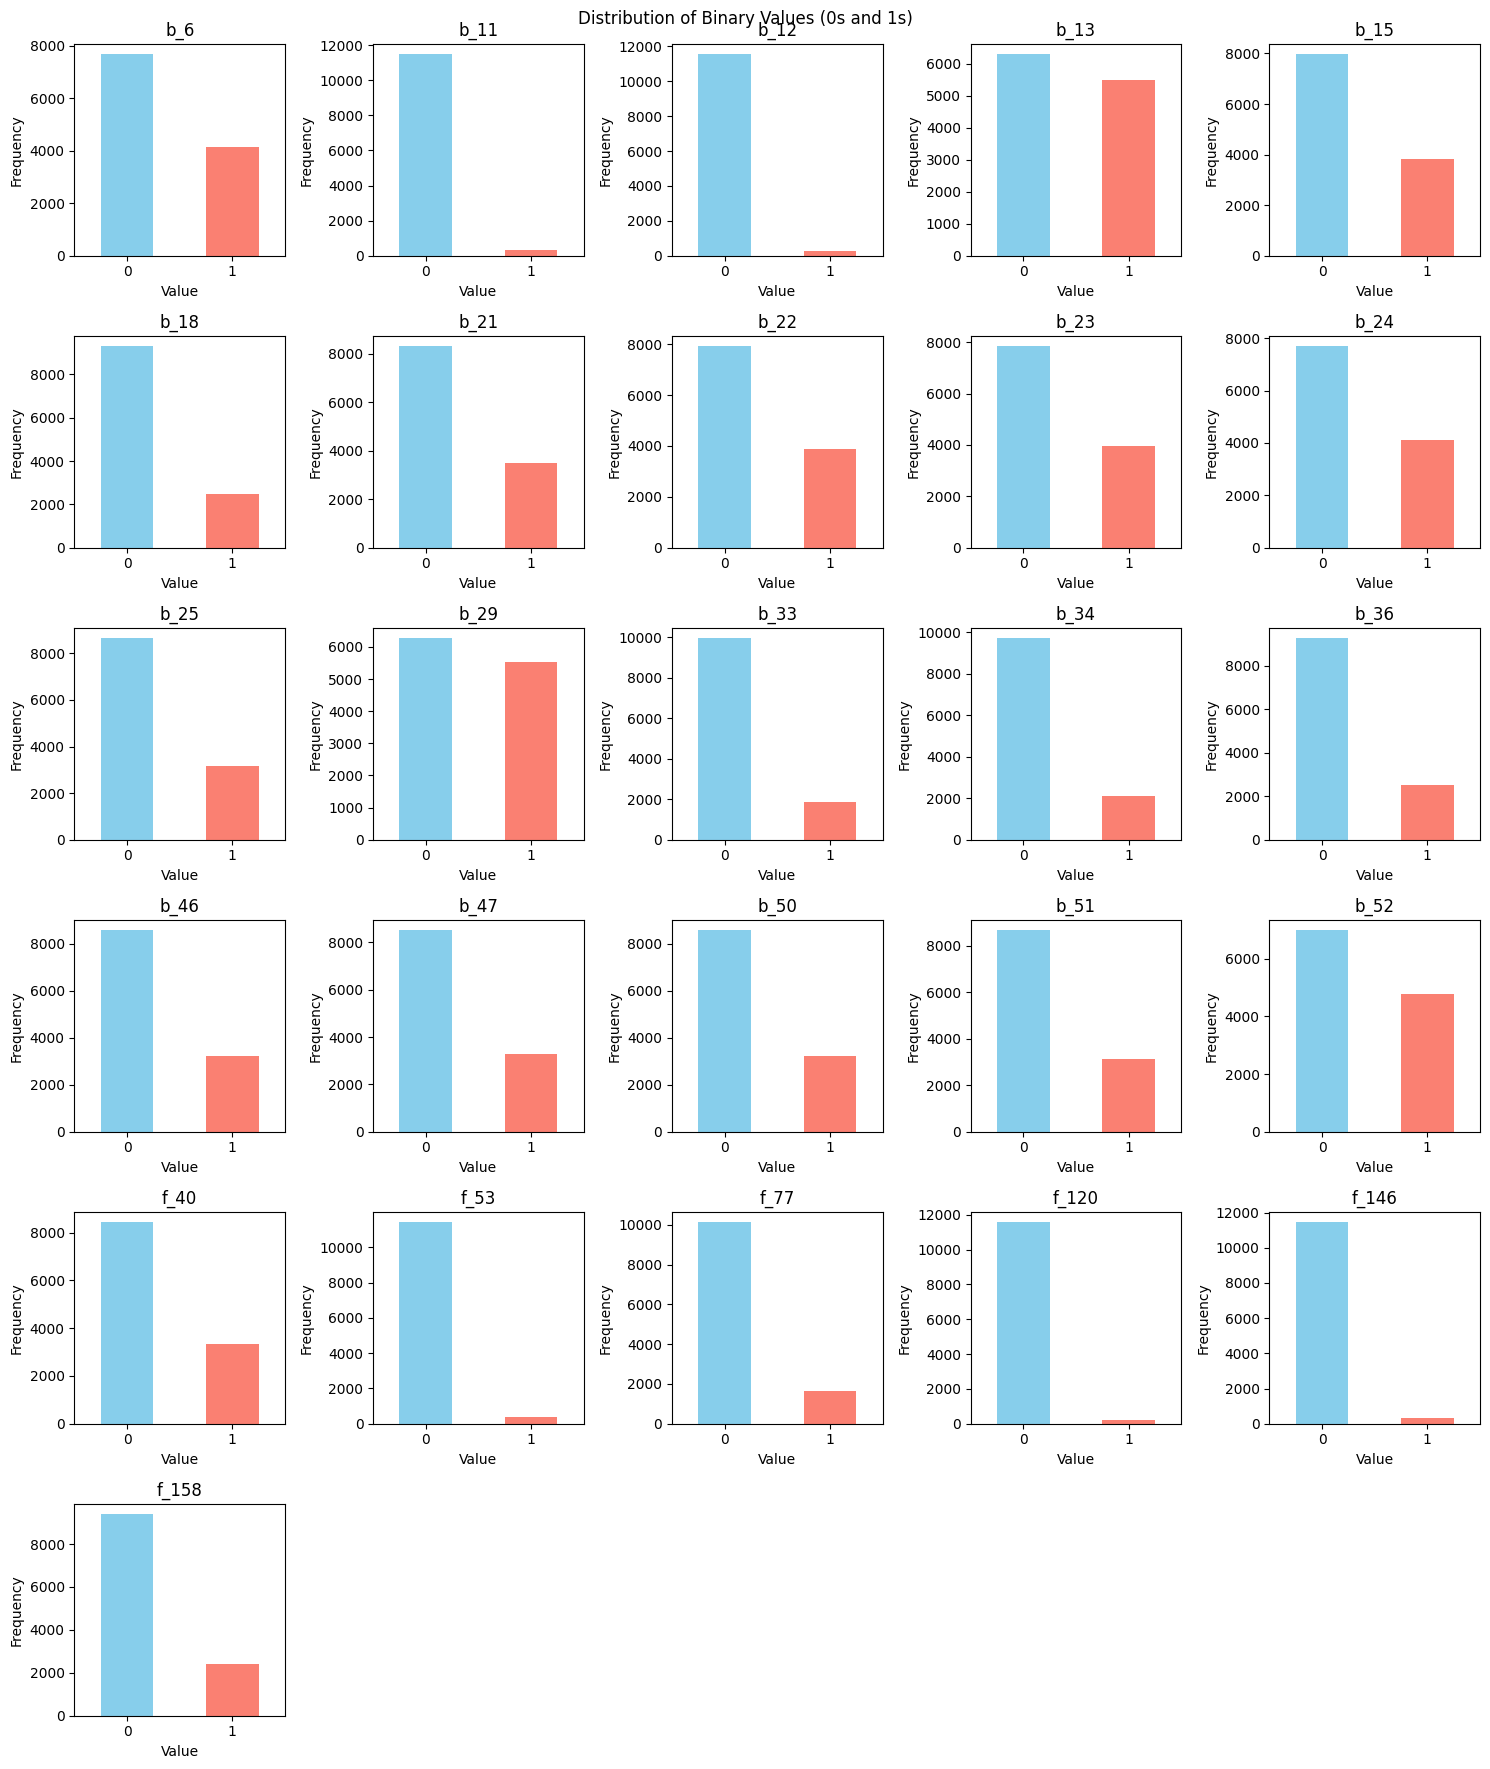

In [ ]:
plot_distribution(targets_combined)

In [ ]:
#Training data for our set 
#We don't shuffle the data set to begin with because the constraints connected through time 
#So we want to main scenarios for our prediction in the PS in gurobi
X_train, X_test, y_train, y_test = train_test_split(df_X, targets_combined, test_size=0.20, random_state=42, shuffle = False)
#We howver shuffle training data 
X_train = X_train.sample(frac=1, random_state = 42)
y_train = y_train.sample(frac=1,random_state = 42)

#Standard scale our training data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
len(X_train)

9427

# SVC

In [ ]:
#Write best params 
best_params = {'C': 1, 'kernel': 'rbf'}

clf_svc = OneVsRestClassifier(SVC(**best_params)).fit(X_train,y_train)
y_pred_svc = clf_svc.predict(X_test)
svc_report = classification_report(y_test, y_pred_svc, target_names=target_names, output_dict = True)
svc_results_df =  pd.DataFrame(svc_report).transpose()
print(svc_report)
svc_results_df.to_csv("SVC_results.csv")

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
{'b_6': {'precision': 0.747872

# Logistic

In [ ]:
#make as a function to run this or not 

best_params_log = {'C': 1, 'fit_intercept': True, 'solver': 'lbfgs'}
clf_log =  OneVsRestClassifier(LogisticRegression(**best_params_log)).fit(X_train,y_train)# 

y_pred_log = clf_log.predict(X_test)
log_report = classification_report(y_test, y_pred_log, target_names=target_names, output_dict = True)
log_results_df =  pd.DataFrame(log_report).transpose()
print(log_report)

{'b_6': {'precision': 0.7621744054360136, 'recall': 0.8050239234449761, 'f1-score': 0.7830133798720186, 'support': 836}, 'b_11': {'precision': 0.6363636363636364, 'recall': 0.3, 'f1-score': 0.4077669902912621, 'support': 70}, 'b_12': {'precision': 0.6071428571428571, 'recall': 0.2786885245901639, 'f1-score': 0.3820224719101123, 'support': 61}, 'b_13': {'precision': 0.9193548387096774, 'recall': 0.946993670886076, 'f1-score': 0.9329696024941543, 'support': 1264}, 'b_15': {'precision': 0.6858513189448441, 'recall': 0.7803547066848567, 'f1-score': 0.7300574345883856, 'support': 733}, 'b_18': {'precision': 0.6179775280898876, 'recall': 0.5228136882129277, 'f1-score': 0.5664263645726055, 'support': 526}, 'b_21': {'precision': 0.7018284106891702, 'recall': 0.7028169014084507, 'f1-score': 0.7023223082336383, 'support': 710}, 'b_22': {'precision': 0.7552275522755227, 'recall': 0.7684605757196495, 'f1-score': 0.7617866004962779, 'support': 799}, 'b_23': {'precision': 0.9699680511182108, 'recall

In [ ]:
clf_tree = MultiOutputClassifier(RandomForestClassifier())
"""
#Remove comment when done ( this takes awhile to do , can proabably be less involved tbf)
params_tree = {
    'estimator__n_estimators': [i for i in range(50, 225, 75)],
    'estimator__max_depth': [10, 20, 30, ],
    'estimator__max_features': ['auto', 'sqrt', 'log2']
    
clf_tree_grid = GridSearchCV (clf_tree, params_tree, cv=4, return_train_score=False).fit(X_train, y_train)

print (clf_tree_grid.best_score_) # Best Score = 0.2034
print (clf_tree_grid.best_params_) # Best parameters = {'estimator__fit_intercept': True, 'estimator__solver': 'lbfgs'}

}
"""


"\n#Remove comment when done ( this takes awhile to do , can proabably be less involved tbf)\nparams_tree = {\n    'estimator__n_estimators': [i for i in range(50, 225, 75)],\n    'estimator__max_depth': [10, 20, 30, ],\n    'estimator__max_features': ['auto', 'sqrt', 'log2']\n    \nclf_tree_grid = GridSearchCV (clf_tree, params_tree, cv=4, return_train_score=False).fit(X_train, y_train)\n\nprint (clf_tree_grid.best_score_) # Best Score = 0.2034\nprint (clf_tree_grid.best_params_) # Best parameters = {'estimator__fit_intercept': True, 'estimator__solver': 'lbfgs'}\n\n}\n"

In [ ]:
print(y_pred_log.shape)
print(y_test.shape)
print(targets_combined.shape)

(2357, 26)
(2357, 26)
(11784, 26)


# Random Forrest regressor with optimal parameters

In [ ]:
"""#best_params_tree = 
clf_tree = MultiOutputClassifier(RandomForestClassifier()).fit(X_train,y_train)
y_pred_tree = clf_tree.predict(X_test)


tree_report = classification_report(y_test, y_pred_tree, target_names=target_names, output_dict = True)
tree_results_df =  pd.DataFrame(tree_report).transpose()

#print(tree_report)"""

'#best_params_tree = \nclf_tree = MultiOutputClassifier(RandomForestClassifier()).fit(X_train,y_train)\ny_pred_tree = clf_tree.predict(X_test)\n\n\ntree_report = classification_report(y_test, y_pred_tree, target_names=target_names, output_dict = True)\ntree_results_df =  pd.DataFrame(tree_report).transpose()\n\n#print(tree_report)'

In [ ]:
estimators = np.arange(len(target_names))
#plot_ROC(estimators,target_names)

## Compare ROC curves for some different target variables 

# PCA

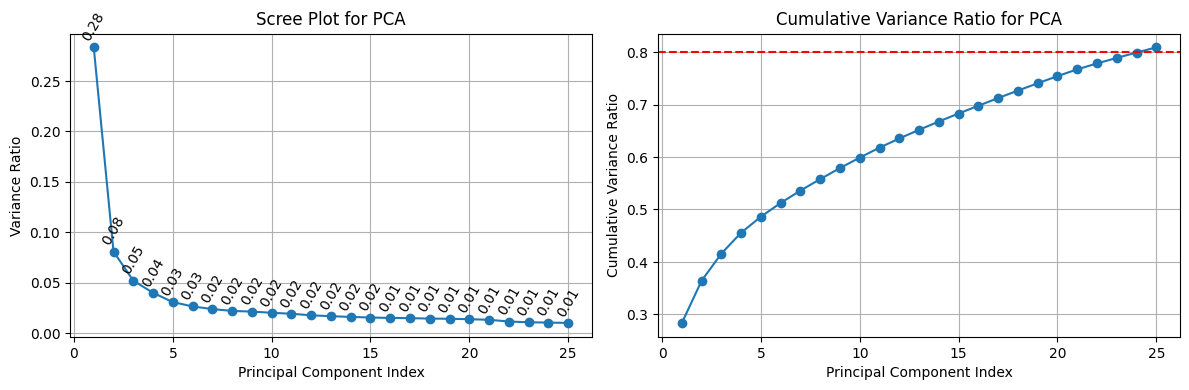

[0.28329489 0.08069637 0.05185643 0.03976791 0.03057084 0.02623995
 0.02364063 0.02179157 0.02115241 0.01995777 0.01900886 0.01744505
 0.01657637 0.01585751 0.015275   0.01485174 0.01463804 0.01420751
 0.01399746 0.01361712 0.01299389 0.01129756 0.01054155 0.01025787
 0.00988295]


In [ ]:
# Perform PCA
pca = PCA(n_components=25)
pca.fit(df_demands)

# Scree plot and Cumulative plot
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Scree plot (explained variance ratio)
axs[0].plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
axs[0].set_xlabel('Principal Component Index')
axs[0].set_ylabel('Variance Ratio')
axs[0].set_title('Scree Plot for PCA')
axs[0].grid(True)

# Annotate points with values
for i, txt in enumerate(pca.explained_variance_ratio_):
    axs[0].annotate(f'{txt:.2f}', (i + 1, txt), textcoords="offset points", xytext=(0,5), ha='center', rotation=60)


# Cumulative plot
axs[1].plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
axs[1].set_xlabel('Principal Component Index')
axs[1].set_ylabel('Cumulative Variance Ratio')
axs[1].set_title('Cumulative Variance Ratio for PCA')
axs[1].axhline(y=0.8, color='red', linestyle='--', label='80% Cumulative Variance')
axs[1].grid(True)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()

print(pca.explained_variance_ratio_)

In [ ]:
pca_data = pca.fit_transform(df_demands)

# Project Data onto PCA Components
projected_data = pca.transform(df_demands)

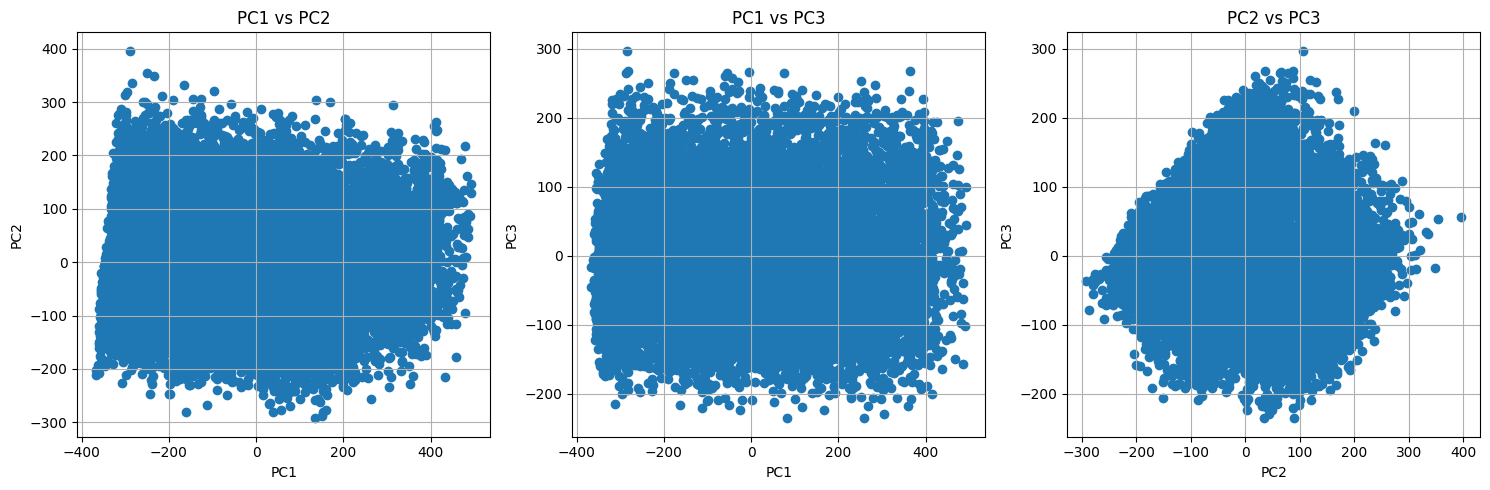

In [ ]:
# Create subplots for the first 3 components
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot PC1 vs PC2
axs[0].scatter(projected_data[:, 0], projected_data[:, 1])
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].set_title('PC1 vs PC2')
axs[0].grid(True)

# Plot PC1 vs PC3
axs[1].scatter(projected_data[:, 0], projected_data[:, 2])
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC3')
axs[1].set_title('PC1 vs PC3')
axs[1].grid(True)

# Plot PC2 vs PC3
axs[2].scatter(projected_data[:, 1], projected_data[:, 2])
axs[2].set_xlabel('PC2')
axs[2].set_ylabel('PC3')
axs[2].set_title('PC2 vs PC3')
axs[2].grid(True)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()


### First visualization of the projected data onto the Principal Components (3 PCs)

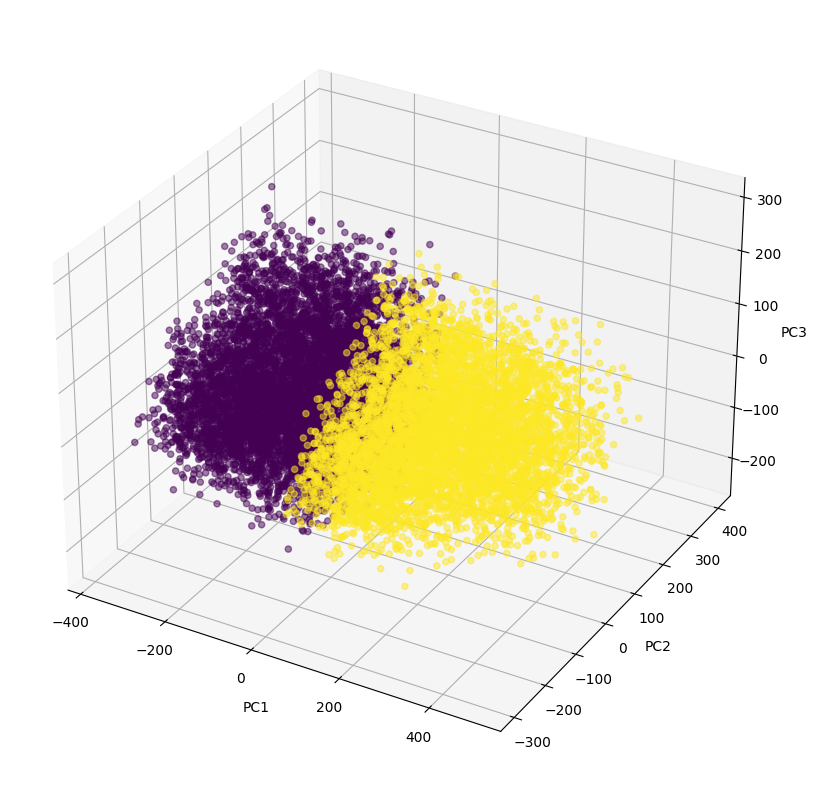

In [ ]:
pca = PCA(n_components=3)
pca.fit(df_demands)
projected_data = pca.transform(df_demands)

# Perform k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # You can choose the number of clusters (k) as per your requirement
kmeans.fit(projected_data)
labels = kmeans.labels_

# Biplot with 3 PCs and k-means clustering
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the first three principal components with color-coded clusters
scatter = ax.scatter(projected_data[:, 0], projected_data[:, 1], projected_data[:, 2], c= labels , cmap='viridis', alpha=0.5)

# Arrows for the loadings on PC1, PC2, and PC3
for i in range(len(pca.components_)):
    ax.quiver(0, 0, 0, pca.components_[i, 0], pca.components_[i, 1], pca.components_[i, 2], color='r', alpha=0.5)
    if labels is not None:
        ax.text(pca.components_[i, 0] * 1.15, pca.components_[i, 1] * 1.15, pca.components_[i, 2] * 1.15, labels[i], color='g', ha='center', va='center')

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.grid()     


### Plot of the projection of the training set onto the 2 first PC

In [ ]:
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)

# Create a DataFrame for the transformed data
df_pca_train = pd.DataFrame(data=X_train_pca, columns=['Principal Component 1', 'Principal Component 2'])
df_pca_train['Target'] = y_train.values[:, 0]  


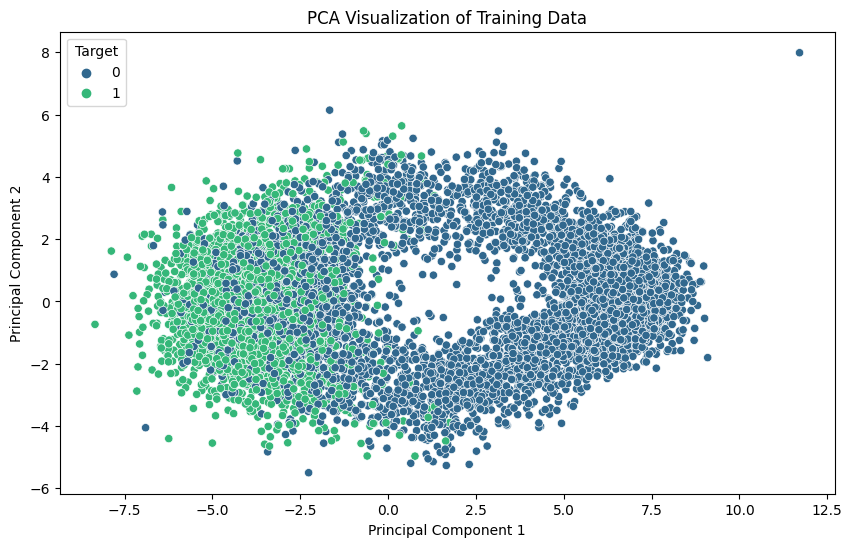

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Target', data=df_pca_train, palette='viridis')
plt.title('PCA Visualization of Training Data')
plt.show()

### Plot of the projection of the test set onto the 2 first PC

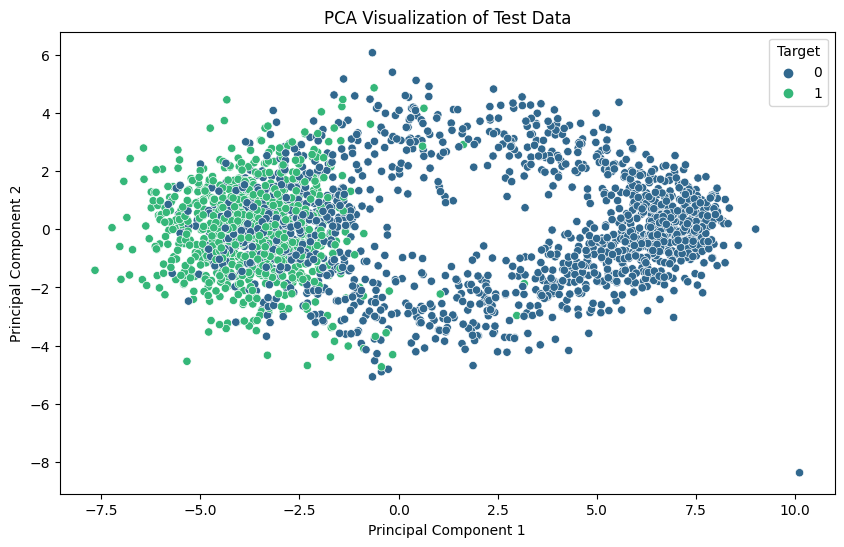

In [ ]:
X_test_pca = pca.transform(X_test)

df_pca_test = pd.DataFrame(data=X_test_pca, columns=['Principal Component 1', 'Principal Component 2'])
df_pca_test['Target'] = y_test.values[:, 0]  # Assuming the first target for visualization

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Target', data=df_pca_test, palette='viridis')
plt.title('PCA Visualization of Test Data')
plt.show()

### Plot of the projection of the classified data onto the 2 first PC - Logistic

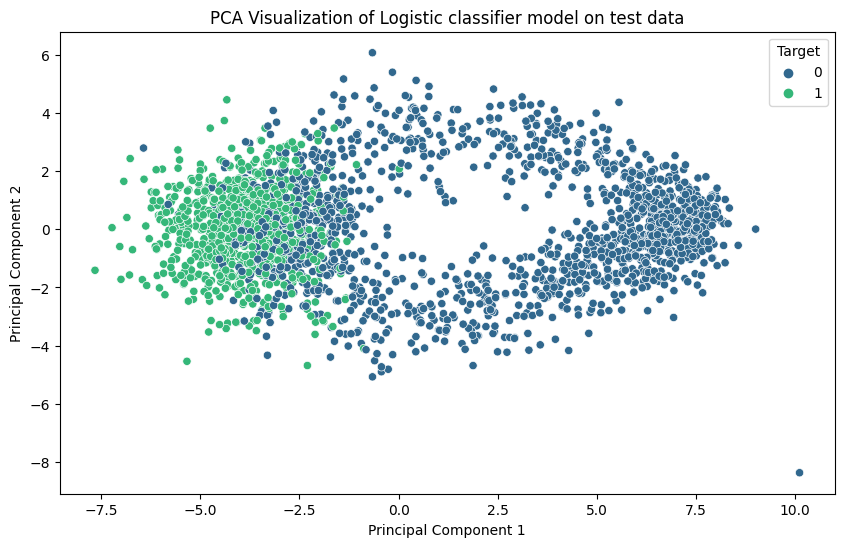

In [ ]:
X_test_pca = pca.transform(X_test)

df_pca_test = pd.DataFrame(data=X_test_pca, columns=['Principal Component 1', 'Principal Component 2'])
df_pca_test['Target'] = y_pred_log[:, 0]  # Assuming the first target for visualization

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Target', data=df_pca_test, palette='viridis')
plt.title('PCA Visualization of Logistic classifier model on test data')
plt.show()

### Plot of the projection of the classified data onto the 2 first PC - SVC

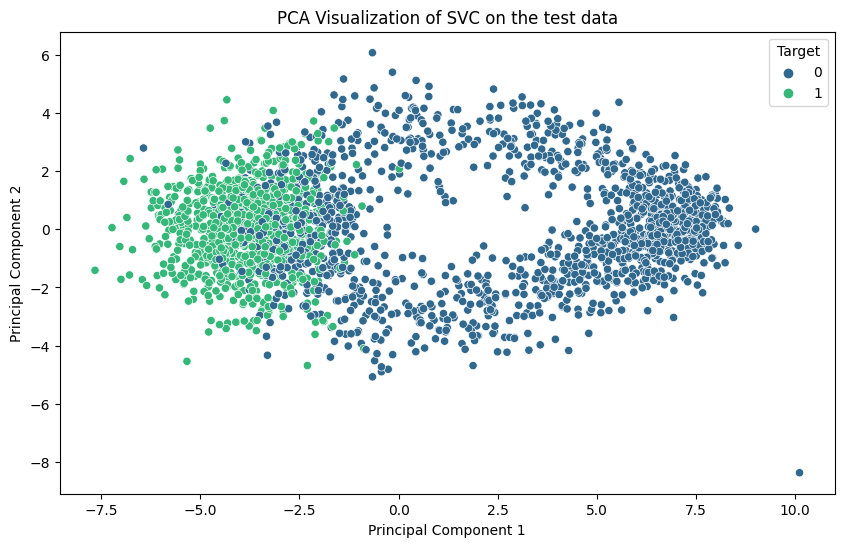

In [ ]:
X_test_pca = pca.transform(X_test)


df_pca_test = pd.DataFrame(data=X_test_pca, columns=['Principal Component 1', 'Principal Component 2'])
df_pca_test['Target'] = y_pred_svc[:, 0]  

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Target', data=df_pca_test, palette='viridis')
plt.title('PCA Visualization of SVC on the test data')
plt.show()

### Plot of the projection of the classified data onto the 2 first PC - Random Forest Classifier

In [ ]:
clf_tree = MultiOutputClassifier(RandomForestClassifier()).fit(X_train,y_train)
y_pred_tree = clf_tree.predict(X_test)


tree_report = classification_report(y_test, y_pred_tree, target_names=target_names, output_dict = True)
tree_results_df =  pd.DataFrame(tree_report).transpose()

#print(tree_report)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


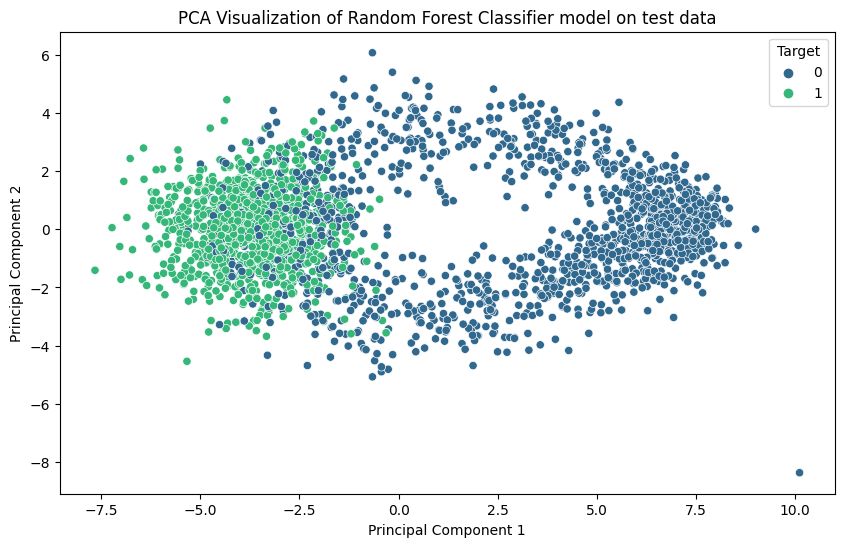

In [ ]:
X_test_pca = pca.transform(X_test)

df_pca_test = pd.DataFrame(data=X_test_pca, columns=['Principal Component 1', 'Principal Component 2'])
df_pca_test['Target'] = y_pred_tree[:, 0]  # Assuming the first target for visualization

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Target', data=df_pca_test, palette='viridis')
plt.title('PCA Visualization of Random Forest Classifier model on test data')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4d433c74-094f-4b64-b183-e04fb92f095e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>